In [ ]:
!pip install pandas numpy scikit-learn transformers datasets evaluate plotly accelerate

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
from datasets import load_dataset

# Data Colection

In [ ]:
## Data Collection: https://huggingface.co/datasets/financial_phrasebank

dataset = load_dataset('financial_phrasebank', 'sentences_allagree')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [ ]:
tmp_df = dataset['train'].to_pandas()

In [ ]:
tmp_df['label'].unique()

array([1, 2, 0])

In [ ]:
tmp_df.head()

sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2

# Exploratory Data Analysis (EDA)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.pie(tmp_df, names
             = 'label', labels = 'label')
fig

In [ ]:
tmp_df['length_text'] = tmp_df['sentence'].apply(lambda x: len(str(x)))

In [ ]:
fig = px.box(tmp_df, x = 'label', y = 'length_text')
fig

In [ ]:
tmp_df.head()

sentence  label  length_text
0  According to Gran , the company has no plans t...      1          127
1  For the last quarter of 2010 , Componenta 's n...      2          193
2  In the third quarter of 2010 , net sales incre...      2          125
3  Operating profit rose to EUR 13.1 mn from EUR ...      2          122
4  Operating profit totalled EUR 21.1 mn , up fro...      2          103

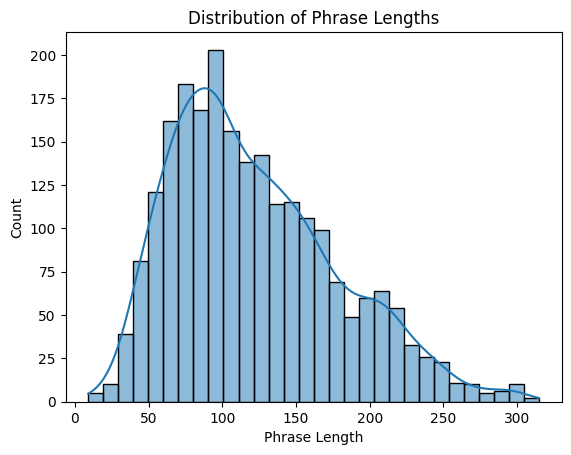

In [ ]:
phrase_length = pd.DataFrame(data=dataset["train"]).apply(lambda x : len(x["sentence"]), axis=1)
sns.histplot(phrase_length, bins=30, kde=True)
plt.title('Distribution of Phrase Lengths')
plt.xlabel('Phrase Length')
plt.show()

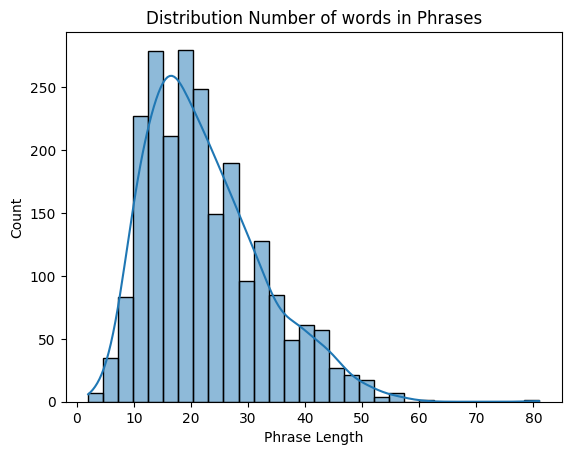

In [ ]:
number_words = pd.DataFrame(data=dataset["train"]).apply(lambda x : len(x["sentence"].split(" ")), axis=1)
sns.histplot(number_words, bins=30, kde=True)
plt.title('Distribution Number of words in Phrases')
plt.xlabel('Phrase Length')
plt.show()

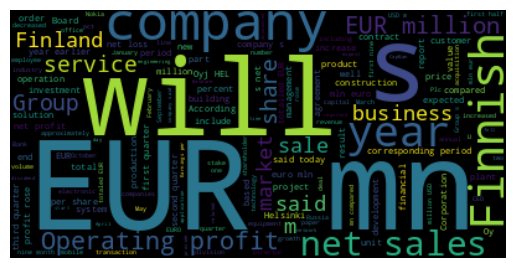

In [ ]:
import wordcloud

text = " ".join(dataset["train"]["sentence"])
wordcloud = WordCloud(max_font_size=None).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Pre-processing & Text Cleaning

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(row):
  data = row.lower()
  data = re.sub(r'[^a-zA-Z0-9\s.]', ' ', data)
  data = re.sub(r'( ){2,}', ' ', data)
  data = word_tokenize(data)
  data = [word for word in data if word not in stop_words]
  data = [lemmatizer.lemmatize(word) for word in data]
  return " ".join(data)

tmp_df['cleaned_text'] = tmp_df["sentence"].apply(clean_text)

In [ ]:
tmp_df.head()

sentence  label  length_text  \
0  According to Gran , the company has no plans t...      1          127   
1  For the last quarter of 2010 , Componenta 's n...      2          193   
2  In the third quarter of 2010 , net sales incre...      2          125   
3  Operating profit rose to EUR 13.1 mn from EUR ...      2          122   
4  Operating profit totalled EUR 21.1 mn , up fro...      2          103   

                                        cleaned_text  
0  according gran company plan move production ru...  
1  last quarter 2010 componenta net sale doubled ...  
2  third quarter 2010 net sale increased 5.2 eur ...  
3  operating profit rose eur 13.1 mn eur 8.7 mn c...  
4  operating profit totalled eur 21.1 mn eur 18.6...

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

text = tmp_df['cleaned_text']
model = CountVectorizer(ngram_range = (1, 1), stop_words='english')
matrix = model.fit_transform(text).toarray()
df_output = pd.DataFrame(data = matrix, columns = model.get_feature_names_out())
df_output.T.tail(5)

0     1     2     3     4     5     6     7     8     9     ...  2254  \
zgody      0     0     0     0     0     0     0     0     0     0  ...     0   
zinc       0     0     0     0     0     0     0     0     0     0  ...     0   
zoltan     0     0     0     0     0     0     0     0     0     0  ...     0   
zone       0     0     0     0     0     0     0     0     0     0  ...     0   
zu         0     0     0     0     0     0     0     0     0     0  ...     0   

        2255  2256  2257  2258  2259  2260  2261  2262  2263  
zgody      0     0     0     0     0     0     0     0     0  
zinc       0     0     0     0     0     0     0     0     0  
zoltan     0     0     0     0     0     0     0     0     0  
zone       0     0     0     0     0     0     0     0     0  
zu         0     0     0     0     0     0     0     0     0  

[5 rows x 2264 columns]

In [ ]:
def get_ngrams(text, ngram_from=2, ngram_to=2, n=None, max_features=20000):

    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to),
                          max_features = max_features,
                          stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

    return words_freq[:n]

In [ ]:
bigrams = get_ngrams(tmp_df['cleaned_text'], ngram_from=2, ngram_to=2, n=150)
bigrams_df = pd.DataFrame(bigrams)
bigrams_df.columns=["Bigram", "Frequency"]
bigrams_df.head()

Bigram  Frequency
0                eur mn        165
1              net sale        147
2      operating profit        146
3                mn eur        119
4  corresponding period         91

In [ ]:
px.bar(bigrams_df, x = 'Bigram', y = 'Frequency')

# Train Sentiment Analysis ML Models using TF-IDF / BoW !

## BoW

In [ ]:
vectorizer = CountVectorizer(max_features = 1000, min_df = 0.1, stop_words='english')

from sklearn.model_selection import train_test_split

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

vectorizer.get_feature_names_out()[:10]

array(['company', 'eur', 'mn', 'net', 'profit', 'sale', 'year'],
      dtype=object)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

y_predictions = clf.predict(X_test)

accuracy_score( y_test, y_predictions)

0.7218543046357616

## BoW + N-grams

In [ ]:
vectorizer = CountVectorizer(max_features = 1000, min_df = 0.05, stop_words='english', ngram_range=(1,3))

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predictions = clf.predict(X_test)
print('Accuracy (BoW + Ngrams): ', accuracy_score( y_test, y_predictions) )

Accuracy (BoW + Ngrams):  0.7615894039735099


# TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000, stop_words='english')

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predictions = clf.predict(X_test)
print('Accuracy (TF-IDF): ', accuracy_score( y_test, y_predictions) )

Accuracy (TF-IDF):  0.8189845474613686


# TF-IDF + N-grams

In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000, stop_words='english', ngram_range=(1,4))

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predictions = clf.predict(X_test)
print('Accuracy (TF-IDF + Ngrams): ', accuracy_score( y_test, y_predictions) )

Accuracy (TF-IDF + Ngrams):  0.8145695364238411


In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(max_features = 10000, stop_words='english', ngram_range=(1,4))

X = tmp_df['cleaned_text'].values
X = vectorizer.fit_transform(X)
y = tmp_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

# Define classifiers
classifiers = {
    'Logistic Regression OVR': LogisticRegression(multi_class='ovr'),
    'Logistic Regression Multinomial': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Feature extraction methods
feature_methods = {
    'BoW': CountVectorizer(),
    'TF-IDF': TfidfVectorizer()
}

# Experimentation
for method_name, vectorizer in feature_methods.items():
    # Apply feature extraction
    # X = vectorizer.fit_transform(texts)
    # X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    for classifier_name, classifier in classifiers.items():
        # Train and evaluate the model
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        print(f"Method: {method_name}, Classifier: {classifier_name}")
        print(f"score: {accuracy_score(y_test, predictions)}")

Method: BoW, Classifier: Logistic Regression OVR
score: 0.8013245033112583
Method: BoW, Classifier: Logistic Regression Multinomial
score: 0.8145695364238411
Method: BoW, Classifier: Random Forest
score: 0.82560706401766
Method: BoW, Classifier: SVM
score: 0.8079470198675497
Method: TF-IDF, Classifier: Logistic Regression OVR
score: 0.8013245033112583
Method: TF-IDF, Classifier: Logistic Regression Multinomial
score: 0.8145695364238411
Method: TF-IDF, Classifier: Random Forest
score: 0.8189845474613686
Method: TF-IDF, Classifier: SVM
score: 0.8079470198675497


In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

scores = {'Logistic Regression OVR': [],
    'Logistic Regression Multinomial': [],
    'Random Forest': [],
    'SVM': []}

# Define classifiers
classifiers = {
    'Logistic Regression OVR': LogisticRegression(multi_class='ovr'),
    'Logistic Regression Multinomial': LogisticRegression(multi_class='multinomial'),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Feature extraction methods
feature_methods = {
    'BoW': CountVectorizer,
    'TF-IDF': TfidfVectorizer
}

# N-Gram Ranges to test
n_gram_ranges = [(1, n) for n in range(2, 6)]  # Example: testing up to 5-grams

# Experimentation
for method_name, vectorizer in feature_methods.items():
    for n_gram_range in n_gram_ranges:
        # # Apply feature extraction
        vect = TfidfVectorizer(max_features = 10000, stop_words='english', ngram_range=n_gram_range)

        X = tmp_df['cleaned_text'].values
        X = vect.fit_transform(X)
        y = tmp_df['label'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        for classifier_name, classifier in classifiers.items():
            # Train and evaluate the model
            classifier.fit(X_train, y_train)
            predictions = classifier.predict(X_test)
            scores.update({classifier_name : scores[classifier_name]+ [(method_name, n_gram_range, accuracy_score(y_test, predictions))]})
            #print(f"Method: {method_name}, N-Gram Range: {n_gram_range}, Classifier: {classifier_name}")
            #print(accuracy_score(y_test, predictions))

In [ ]:
scores

{'Logistic Regression OVR': [('BoW', (1, 2), 0.7858719646799117),
  ('BoW', (1, 3), 0.8013245033112583),
  ('BoW', (1, 4), 0.8013245033112583),
  ('BoW', (1, 5), 0.7969094922737306),
  ('TF-IDF', (1, 2), 0.7858719646799117),
  ('TF-IDF', (1, 3), 0.8013245033112583),
  ('TF-IDF', (1, 4), 0.8013245033112583),
  ('TF-IDF', (1, 5), 0.7969094922737306)],
 'Logistic Regression Multinomial': [('BoW', (1, 2), 0.8057395143487859),
  ('BoW', (1, 3), 0.8167770419426048),
  ('BoW', (1, 4), 0.8145695364238411),
  ('BoW', (1, 5), 0.8145695364238411),
  ('TF-IDF', (1, 2), 0.8057395143487859),
  ('TF-IDF', (1, 3), 0.8167770419426048),
  ('TF-IDF', (1, 4), 0.8145695364238411),
  ('TF-IDF', (1, 5), 0.8145695364238411)],
 'Random Forest': [('BoW', (1, 2), 0.8322295805739515),
  ('BoW', (1, 3), 0.8300220750551877),
  ('BoW', (1, 4), 0.8410596026490066),
  ('BoW', (1, 5), 0.82560706401766),
  ('TF-IDF', (1, 2), 0.8300220750551877),
  ('TF-IDF', (1, 3), 0.8145695364238411),
  ('TF-IDF', (1, 4), 0.8256070640

# Train Word2Vec for Sentiment Analysis

In [ ]:
# Gensim / sklearn
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

texts = [i.split() for i in tmp_df['cleaned_text']]
model = Word2Vec(sentences=texts, vector_size=300, window=10, min_count=2, workers=4)

print(len(model.wv))

2716


In [ ]:
from gensim.models import Word2Vec
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def document_vector(doc):
    word_vectors = [model.wv[word] for word in doc if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

tmp_df['word2vec_avg'] = tmp_df['cleaned_text'].apply(lambda x: document_vector(x.split()))

X_train, X_test, y_train, y_test = train_test_split(tmp_df['word2vec_avg'].tolist(), tmp_df['label'], test_size=0.2, random_state=42)

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6269315673289183


# Topic Modelling (LDA / NMF ) & Visualization of Topcis

In [ ]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1), min_df = 0.1,
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(tmp_df['cleaned_text'].tolist())

# Define the number of topics or components
num_components=5
# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)
# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)
# Get Components
lda_components=model.components_

# Print the topics with their terms
terms = tfidf.get_feature_names_out()
for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Topic 0:  ['profit', 'net', '1', 'year', 'eur', 'company', 'sale']
Topic 1:  ['eur', '1', 'year', 'profit', 'net', 'company', 'sale']
Topic 2:  ['company', 'year', 'net', 'profit', 'eur', '1', 'sale']
Topic 3:  ['sale', 'net', 'year', 'eur', '1', 'company', 'profit']
Topic 4:  ['mn', 'eur', 'profit', '1', 'net', 'year', 'sale']


Number of unique tokens: 482
Number of documents: 2264
[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1)]]
[(0, '0.100*"company" + 0.040*"finland" + 0.037*"group" + 0.036*"business" + 0.033*"finnish" + 0.032*"said" + 0.029*"service" + 0.028*"operation" + 0.025*"product" + 0.023*"also"'), (1, '0.091*"mln" + 0.090*"quarter" + 0.062*"net" + 0.061*"euro" + 0.054*"first" + 0.049*"profit" + 0.035*"fell" + 0.033*"finnish" + 0.033*"year" + 0.027*"third"'), (2, '0.196*"sale" + 0.099*"net" + 0.084*"decreased" + 0.037*"operating" + 0.036*"period" + 0.035*"profit" + 0.030*"increased" + 0.030*"year" + 0.023*"compared" + 0.021*"country"'), (3, '0.042*"system" + 0.036*"production" + 0.034*"cost" + 0.032*"includes" + 0.031*"paper" + 0.026*"passenger" + 0.022*"may" + 0.021*"facility" + 0.021*"estimate" + 0.021*"design"'), (4, '0.058*"today" + 0.050*"oyj" + 0.047*"solution" + 0.046*"million" + 0.045*"usd" + 0.040*"expected" + 0.039*"hel" + 0.038*"news" + 0.037*"finnish" + 0.033*"said"'), (5, '0.166*"million" + 0

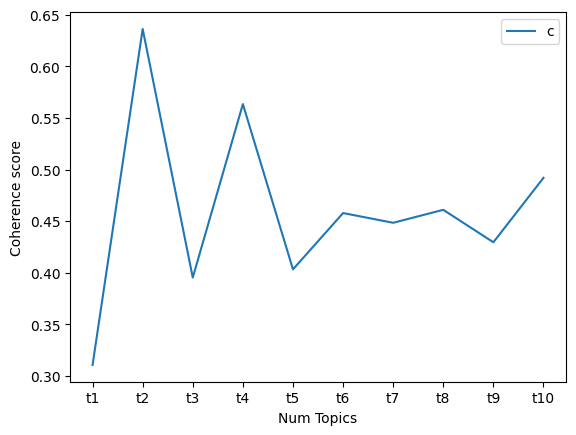

In [ ]:
from gensim.corpora.dictionary import Dictionary
import gensim
from gensim.models import Phrases

#Remove rare & common tokens
# Create a dictionary representation of the documents.
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

docs = list(sent_to_words(tmp_df['cleaned_text'].tolist()))


bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
# Set parameters.
num_topics = 10
chunksize = 500
passes = 20
iterations = 400
eval_every = 1

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Score: ', coherence_ldas)

import matplotlib.pyplot as plt
import numpy as np
topicsname=[]
for i in range(1,num_topics+1):
    topicsname.append("t{0}".format(i))
topicsname

plt.plot(topicsname,coherence_ldas)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
!pip install pyldavis

In [ ]:
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

documents = [sample['sentence'] for sample in dataset['train']]

# Prétraitement des documents : tokenization, suppression des stopwords et création du corpus
stop_words = set(stopwords.words('english'))
texts = []

for document in documents:
    tokens = word_tokenize(document.lower())  # Tokenization et mise en minuscules
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Suppression des stopwords et de la ponctuation
    texts.append(filtered_tokens)

# Création du modèle LDA avec Gensim
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = gensim.models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

# Visualisation avec pyLDAvis
pyLDAvis.enable_notebook()
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



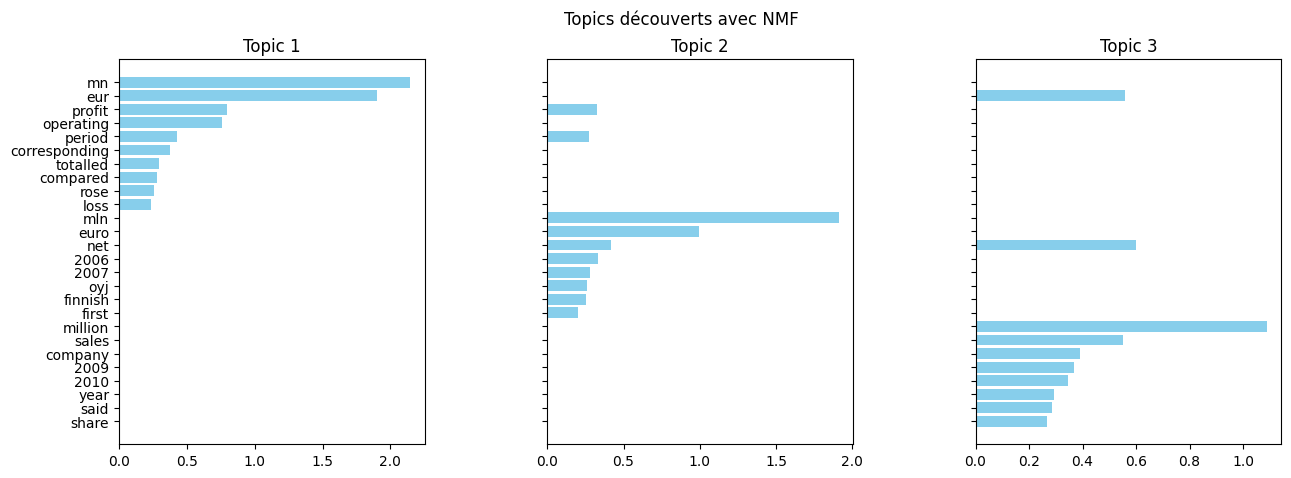

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

documents = [sample['sentence'] for sample in dataset['train']]

# Prétraitement des documents : tokenization, suppression des stopwords
stop_words = set(stopwords.words('english'))
texts = []

for document in documents:
    tokens = word_tokenize(document.lower())  # Tokenization et mise en minuscules
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Suppression des stopwords et de la ponctuation
    texts.append(' '.join(filtered_tokens))

# Création de la matrice TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Entraînement du modèle NMF
num_topics = 3
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Visualisation des thèmes découverts
feature_names = tfidf_vectorizer.get_feature_names_out()

# Création de sous-graphiques pour chaque thème
fig, axes = plt.subplots(1, num_topics, figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0.4)

for topic_idx, ax in enumerate(axes):
    top_words_idx = nmf_model.components_[topic_idx].argsort()[-10:][::-1]  # Top 10 mots-clés pour chaque thème
    top_words = [feature_names[i] for i in top_words_idx]
    top_word_weights = nmf_model.components_[topic_idx][top_words_idx]

    ax.barh(top_words, top_word_weights, color='skyblue')
    ax.invert_yaxis()
    ax.set_title(f"Topic {topic_idx + 1}")

plt.suptitle("Topics découverts avec NMF")
plt.show()

In [ ]:
# Check: https://www.kaggle.com/code/trnduythanhkhttt/lda-and-topic-coherence-score

# Fine-tune LMs for Sentiment Analysis (BERT, RoBERTa, AlBERT, DistilBERT....)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("financial_phrasebank", "sentences_allagree")

## BERT

In [ ]:
from transformers import AutoTokenizer
# ! pip install -U accelerate
# ! pip install -U transformers

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].select(range(1812))
small_eval_dataset = tokenized_datasets["train"].select(range(1812,2264))

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
)

BERT_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
BERT_trainer.train()

In [ ]:
BERT_trainer.evaluate()

{'eval_loss': 0.9179245233535767,
 'eval_accuracy': 0.8097345132743363,
 'eval_runtime': 14.7989,
 'eval_samples_per_second': 30.543,
 'eval_steps_per_second': 0.541,
 'epoch': 3.0}

In [ ]:
BERT_trainer.save_model("./BERT")
tokenizer.save_pretrained("./BERT")

## RoBERTa

In [ ]:
# Importing necessary libraries
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the Financial PhraseBank dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Tokenization function
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Format the dataset for PyTorch
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

split = round(len(tokenized_datasets["train"]) * .8)

# Split the dataset into training and validation sets
train_dataset = tokenized_datasets["train"].select(range(split))
val_dataset = tokenized_datasets["train"].select(range(split,len(tokenized_datasets["train"])))

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)  # Assuming 3 labels

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
)

# Initialize the trainer
RoBERTa_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
RoBERTa_trainer.train()

In [ ]:
RoBERTa_trainer.evaluate()

{'eval_loss': 0.7075947523117065,
 'eval_runtime': 13.3722,
 'eval_samples_per_second': 33.876,
 'eval_steps_per_second': 0.598,
 'epoch': 3.0}

In [ ]:
RoBERTa_trainer.save_model("./RoBERTa")
tokenizer.save_pretrained("./RoBERTa")

## Albert

In [ ]:
# 1. Install Required Libraries
# !pip uninstall sentencepiece -y
!pip install sentencepiece

# 2. Import Libraries
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the Financial PhraseBank dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# Tokenization function
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Format the dataset for PyTorch
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

split = round(len(tokenized_datasets["train"]) * .8)

# Split the dataset into training and validation sets
train_dataset = tokenized_datasets["train"].select(range(split))
val_dataset = tokenized_datasets["train"].select(range(split,len(tokenized_datasets["train"])))


# 6. Initialize the ALBERT Model for Sequence Classification
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)  # Adjust num_labels as needed

# 7. Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
)

# 8. Initialize the Trainer
AlBERT_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)



In [ ]:
AlBERT_trainer.train()

In [3]:
AlBERT_trainer.evaluate()

{'eval_loss': 0.857841432094574,
 'eval_runtime': 16.6448,
 'eval_samples_per_second': 27.216,
 'eval_steps_per_second': 0.481,
 'epoch': 3.0}

In [ ]:
AlBERT_trainer.save_model("./AlBERT")
tokenizer.save_pretrained("./AlBERT")

# Model Evaluation & Explainability

## SHAP

In [ ]:
!pip install shap

In [ ]:
import shap
import torch
import scipy as sp

def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=128, truncation=True)
            for v in x
        ]
    ).cuda()
    attention_mask = (tv != 0).type(torch.int64).cuda()
    outputs = model(tv, attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

labels = sorted(model.config.label2id, key=model.config.label2id.get)

explainer = shap.Explainer(f, tokenizer, output_names=labels)

labels

In [ ]:
shap_values = explainer(dataset['train']['sentence'][:3])

In [ ]:
dataset['train'][:3]

{'sentence': ['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .'],
 'label': [1, 2, 2]}

In [ ]:
shap.plots.text(shap_values)

## BERTopic

In [ ]:
!pip install bertopic

In [ ]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

docs = dataset['train']['sentence']

docs[:1]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .']

In [ ]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(0)

[('mln', 0.05482421396027278),
 ('euro', 0.036911332354934094),
 ('oyj', 0.03449332588159535),
 ('finnish', 0.03240450756693135),
 ('net', 0.030402209312598776),
 ('said', 0.026052773362489064),
 ('hel', 0.025957134830114123),
 ('today', 0.023002215191285823),
 ('profit', 0.022199429809531476),
 ('its', 0.021664219853846017)]

In [ ]:
topic_model.get_topic(9)

[('includes', 0.041835058047131224),
 ('equipment', 0.0411608055381233),
 ('plant', 0.03658738270055404),
 ('heating', 0.03388043114139302),
 ('construction', 0.033567826412094624),
 ('contract', 0.033331348082247234),
 ('installation', 0.032284713373662816),
 ('control', 0.03160433730521121),
 ('with', 0.03144163306439795),
 ('rental', 0.029886623997985064)]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_documents(docs)

In [ ]:
topic_model.visualize_heatmap()

# Pipeline

In [6]:
from transformers import pipeline
import numpy as np

BERT_results = []
RoBERTa_results = []
AlBERT_results = []

indices = np.random.randint(round(len(dataset["train"]) * .8), len(dataset["train"])-1, 10)

phrases = [dataset["train"]["sentence"][i] for i in indices]

results = [dataset["train"]["label"][i] for i in indices]

# Load the pipeline using the fine-tuned model and tokenizer
BERT_sentiment_pipeline = pipeline("sentiment-analysis", model="./BERT", tokenizer="./BERT")
RoBERTa_sentiment_pipeline = pipeline("sentiment-analysis", model="./RoBERTa", tokenizer="./RoBERTa")
AlBERT_sentiment_pipeline = pipeline("sentiment-analysis", model="./AlBERT", tokenizer="./AlBERT")

def check_predict(predictions):
  res = []
  mean_acc = sum([x[0]["score"] for x in predictions]) / len(predictions) * 100

  labels = [x[0]['label'] for x in predictions]
  for i in range(len(labels)-1):
    if labels[i] == "LABEL_" + str(results[i]):
      res.append(1)
  return f"{sum(res)/len(results) * 100}% de précision, {mean_acc} de certitude"

for phrase in phrases:

  # Now you can use the pipeline for sentiment analysis
  BERT_results.append(BERT_sentiment_pipeline(phrase))
  RoBERTa_results.append(RoBERTa_sentiment_pipeline(phrase))
  AlBERT_results.append(AlBERT_sentiment_pipeline(phrase))

print(f'BERT : {check_predict(BERT_results)}', f'RoBERTa : {check_predict(RoBERTa_results)}', f'AlBERT : {check_predict(AlBERT_results)}', sep="\n")


BERT : 70.0% de précision, 97.98879325389862 de certitude
RoBERTa : 70.0% de précision, 98.70727717876434 de certitude
AlBERT : 70.0% de précision, 83.50639343261719 de certitude
